In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import seaborn
import cv2

from PIL import Image

# Data

generate plots with corresponding masks

In [336]:
class PlotDataset(Dataset):
    def __init__(self, num_samples, transform=None, tolerance=5):
        self.num_samples = num_samples
        self.transform = transform
        self.tolerance = tolerance

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate random coefficients
        a1, a2 = np.random.uniform(-10, 10, 2)
        a3, a4, a5 = np.random.uniform(-1, 1, 3)
        
        # Generate x values
        x = np.linspace(-10, 10, 100)
        
        # Generate y values for linear and parabolic functions
        y_linear = a1 * x + a2
        y_parabolic = a3 * x**2 + a4 * x + a5
        
        # Create figure
        fig, ax = plt.subplots(figsize=(32, 32))
        ax.set_xlim(-10, 10)
        ax.set_ylim(-100, 100)
        
        # Plot the linear function
        line_color = np.random.rand(3,)
        ax.plot(x, y_linear, color=line_color)
        
        # Plot the parabolic function
        parab_color = np.random.rand(3,)
        ax.plot(x, y_parabolic, color=parab_color)
        
        # Save plot as image
        fig.canvas.draw()
        image = np.array(fig.canvas.renderer.buffer_rgba())
        plt.close(fig)
        
        # Convert RGBA to RGB
        image = image[:, :, :3]
        
        # Create mask
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        
        # Draw axes on mask (Assuming axes are black lines)
        mask[image[:, :, 0] == 0] = 1
        
        # Define a helper function for color matching with tolerance
        def within_tolerance(img, color, tol):
            return np.all(np.abs(img - np.array(color) * 255) <= tol, axis=-1)
        
        # Add linear function to mask
        mask[within_tolerance(image, line_color, self.tolerance)] = 2
        
        # Add parabolic function to mask
        mask[within_tolerance(image, parab_color, self.tolerance)] = 3
        
        # Apply transformations to image
        if self.transform:
            image = self.transform(image)
        
        # Convert mask to tensor manually to avoid scaling
        mask = torch.tensor(mask, dtype=torch.long)
        
        return image, mask

# Define transformations for the image
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create dataset and dataloader
dataset = PlotDataset(num_samples=1000, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [337]:
# Example usage
for images, masks in dataloader:
    print(images.shape, masks.shape)
    break

fig, axes = plt.subplots(4, 6, figsize=(9, 5))
axes = axes.ravel()

for i in range(6):
    axes[i].imshow(images[i].permute(1,2,0))
    axes[i].axis("off")
    axes[i+6].imshow(masks[i])
    axes[i+6].axis("off")
    axes[i + 6].set_title(f"{np.unique(masks[i])}")

for i in range(6):
    axes[i + 12].imshow(images[i + 6].permute(1,2,0))
    axes[i + 12].axis("off")
    axes[i + 18].imshow(masks[i + 6])
    axes[i + 18].axis("off")
    axes[i + 18].set_title(f"{np.unique(masks[i + 6])}")

plt.tight_layout()
plt.show()

torch.Size([32, 3, 3200, 3200]) torch.Size([32, 3200, 3200])


/var/folders/yt/vsz4v53j4bv674jbw4t304p80000gn/T/ipykernel_22286/3856567545.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# Unet

In [224]:
from torch.functional import F
from torch import nn
from torchinfo import summary

CONV_KERNEL = (3, 3)
POOL_KERNEL = (2, 2)
STRIDE_SIZE = (1, 1)
PADDING_TYPE = 1

class DownBlock(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels, **kwargs):
        super(DownBlock, self).__init__(**kwargs)

        self.conv_1 = nn.Conv2d(in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=CONV_KERNEL,
                                padding=PADDING_TYPE)
        self.conv_2 = nn.Conv2d(in_channels=out_channels,
                                out_channels=out_channels,
                                kernel_size=CONV_KERNEL,
                                padding=PADDING_TYPE)
        self.batch_1 = nn.BatchNorm2d(num_features=out_channels)
        self.batch_2 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=POOL_KERNEL)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.relu(x)
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

def UpperBlockCustom(ConvTranspose, in_channels, out_channels):
    class UpperBlock(nn.Module):
        def __init__(self, in_channels: int, out_channels: int, **kwargs):
            super(UpperBlock, self).__init__(**kwargs)
            self.convT = ConvTranspose(in_channels=in_channels,
                                       out_channels=out_channels,
                                       kernel_size=CONV_KERNEL,
                                       stride=STRIDE_SIZE,
                                       padding=PADDING_TYPE)

        def forward(self, x, w=None):
            if w is not None:
                x = self.convT(x, w)
            else:
                x = self.convT(x)
            s = x.shape[2:]
            x = F.interpolate(x,
                              size=(s[0] * 2, s[1] * 2),
                              mode='bilinear',
                              align_corners=False)
            return x

    return UpperBlock(in_channels, out_channels)

n = 6
class UNet(nn.Module):

    def __init__(self, depth: int = 3, **kwargs):
        super(UNet, self).__init__(**kwargs)
        self.depth = depth
        self.down_blocks = nn.ModuleDict()
        self.down_blocks[str(0)] = DownBlock(in_channels=1,
                                        out_channels=64)
        n_feat = 64
        for i in range(1, depth):
            self.down_blocks[str(i)] = DownBlock(in_channels=n_feat,
                                            out_channels=2 * n_feat)
            n_feat *= 2

        self.up_block = nn.ModuleDict()
        self.up_block[str(0)] = UpperBlockCustom(nn.ConvTranspose2d,
                                            64, 1)
        n_feat = 64 * (2 ** (depth - 1)) // 2
        for i in range(1, depth):
            self.up_block[str(depth-i)] = UpperBlockCustom(nn.ConvTranspose2d,
                                                  2 * n_feat, n_feat)
            n_feat //= 2

    def forward(self, x):
        x = self.down_blocks[str(0)](x)
        for i in range(1, self.depth):
            x = self.down_blocks[str(i)](x)
        for i in range(1, self.depth):
            x = self.up_block[str(self.depth - i)](x)
        x = self.up_block[str(0)](x)
        return x

model = UNet(depth=3)
summary(model, input_size=(1, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 128, 128]          --
├─ModuleDict: 1-1                        --                        --
│    └─DownBlock: 2-1                    [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 64, 128, 128]         640
│    │    └─BatchNorm2d: 3-2             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-3                    [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-4                  [1, 64, 128, 128]         36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-6                    [1, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-7               [1, 64, 64, 64]           --
│    └─DownBlock: 2-2                    [1, 128, 32, 32]          --
│    │    └─Conv2d: 3-8                  [1, 128, 64, 64]          73,856
│    │    └─BatchNorm2d: 3-9             [1, 128, 64, 64]          256
│  

In [233]:
target = torch.randint(0, 2, (32, 128, 128))
target.shape

torch.Size([32, 128, 128])

In [255]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Dice Loss for multi-class segmentation
class DiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, logits, targets):
        # Apply softmax to get probabilities
        logits = F.softmax(logits, dim=1)
        
        # One-hot encode the targets
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2).float()
        
        # Compute Dice loss
        intersection = (logits * targets_one_hot).sum(dim=(2, 3))
        union = logits.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        return 1 - dice.mean()

# Define the Combined Loss function
class CombinedLoss(nn.Module):
    def __init__(self, num_classes, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss(num_classes)
        self.ce_loss = nn.CrossEntropyLoss()
        self.alpha = alpha

    def forward(self, logits, targets):
        dice = self.dice_loss(logits, targets)
        ce = self.ce_loss(logits, targets)
        return self.alpha * ce + (1 - self.alpha) * dice

# Dummy model output and target for demonstration
num_classes = 4  # For example, background, axes, linear plot, parabolic plot
output = torch.randn(32, num_classes, 128, 128)  # Model output logits
target = torch.randint(0, num_classes, (32, 128, 128))  # Ground truth mask

# Ensure target is a LongTensor containing class indices
target = target.long()

# Initialize the combined loss function
criterion = CombinedLoss(num_classes)

# Compute the loss
loss = criterion(output, target)
print(f"Loss: {loss.item()}")

Loss: 1.2364288568496704


# Test

In [261]:
from models_zoo.unet import UNet
from data.data import create_dataloader
from utils import plot_hystory, parse_arguments, count_torch_parameters

In [262]:
BATCH_SIZE = 4
IMG_SIZE = 128

In [263]:
test_dataloader = create_dataloader(num_samples=32, batch_size=BATCH_SIZE, shuffle=False, img_size=IMG_SIZE)

model = UNet()
summary(model, input_size=(1, 3, 128, 128))
count_torch_parameters(model)

Trainable parameters: 1703139
Non-trainable parameters: 0
Trainable weights (Mb): 6.812556
Non-trainable weights (Mb): 0.0


In [310]:
for X, mask in test_dataloader:
    pred = model(X)
    break

pred.shape, mask.shape

(torch.Size([4, 3, 128, 128]), torch.Size([4, 128, 128]))

# npy images

In [169]:
for i in range(128):
    img = np.load(f'./data/test/image/{i}.npy')
    mask = np.load(f'./data/test/mask/{i}.npy')

    fig, axes = plt.subplots(1, 2, figsize=(9, 5))
    axes[0].imshow(np.transpose(img, (1,2,0)))
    axes[1].imshow(mask)
    axes[1].set_title(np.unique(mask))
    plt.savefig(f"./data/test_dataset/{i}.png")
    plt.close(fig)

----> [0. 1.]


Text(0.5, 1.0, '[0 1 2]')

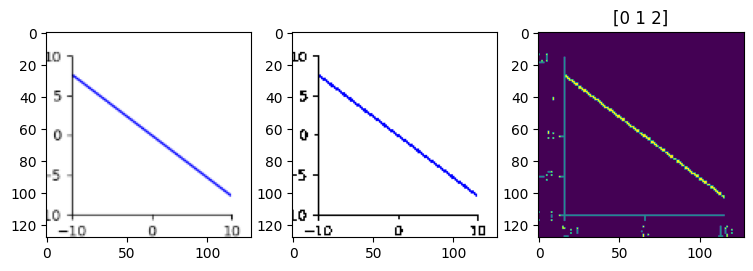

In [233]:
i = 0
img = np.load(f'./data/train/image/{i}.npy')
mask = np.load(f'./data/train/mask/{i}.npy')
_, thresh = cv2.threshold(img, 0.7, 1, cv2.THRESH_BINARY)
print("---->", np.unique(thresh))

fig, axes = plt.subplots(1, 3, figsize=(9, 5))
axes[0].imshow(np.transpose(img, (1,2,0)))
axes[1].imshow(np.transpose(thresh, (1,2,0)))
axes[2].imshow(mask)
axes[2].set_title(np.unique(mask))

In [226]:
def to_edge(img):
    img = img.astype(np.uint8)
    edges = cv2.Canny(img, threshold1=50, threshold2=150)
    return edges

def preprocess_image(i):
    image = np.load(f"./data/train/image/{i}.npy") * 255
    for i in range(3):
        image[i] = to_edge(image[i])
    return image / 255.

edged = preprocess_image(1)

[0. 1.]


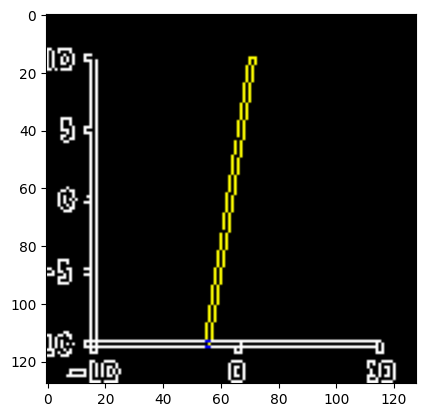

In [231]:
plt.imshow(np.transpose(edged, (1,2,0)))
print(np.unique(edged))

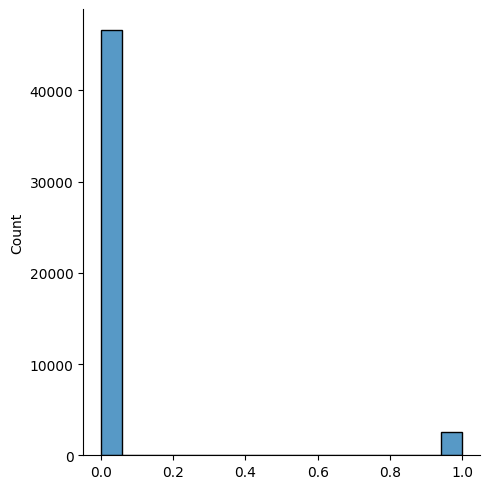

In [228]:
sns.displot(edged.reshape(-1))